In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway
from skbio.stats.ordination import pcoa

In [18]:
concentracoes_padrao = [0.25, 0.5, 0.75, 1.0]

X = np.array(concentracoes_padrao).reshape(-1,1)

modelo = LinearRegression()

def pi_calc(L, a, b, d, f1 = 1.2, f2 = 50):
    '''Função que calcula fósforo inorgânico (Pi)
       para uma determinada leitura, com base em
       uma curva de calibração.
    
       Parâmetros:

       L: valor da leitura da amostra em absorbância
       a: coeficiente angular da reta dos padrões
       b: coeficiente linear da reta dos padrões
       d: fator de diluição do extrato
       f1: fator de diluição da leitura da amostra (2,5 mL alíquota + 0,5 mL RT)
       f2: fator de diluição solo:extrator (0,5:30)

       Retorna:

       Quantidade de P inorgânico.
    '''
    pi = ((L-b)/a)*d*f1*f2

    return pi

def calc_densidade_P(massa_g, c_mgkg, volume_dm3 = 0.1):
   """
   Calcula a densidade do solo e a concentração de fósforo em mg/dm³.

   Parâmetros:
   
   massa_g: massa da amostra em gramas.
   volume_dm3: volume da amostra em decímetros cúbicos (dm³).
   c_mgkg: concentração de fósforo em mg/kg.

   Retorna:
   
   densidade_gcm3: densidade da amostra em g/cm³.
   p_mg_dm3: concentração de fósforo em mg/dm³.
   """
   densidade_gcm3 = (massa_g / volume_dm3) / 1000

   p_mg_dm3 = c_mgkg * densidade_gcm3

   return densidade_gcm3, p_mg_dm3

### P inorgânico. Extratora hcl1M

In [19]:
#Padrões
p025_hcl1M = pd.read_csv('MD_P_padrao_0,25_25_09_2025.txt', encoding="cp1252", sep=",", skiprows=range(0, 42))
p05_hcl1M = pd.read_csv('MD_P_padrao_0,5_25_09_2025.txt', encoding="cp1252", sep=",", skiprows=range(0, 42))
p075_hcl1M = pd.read_csv('MD_P_padrao_0,75_25_09_2025.txt', encoding="cp1252", sep=",", skiprows=range(0, 42))
p1_hcl1M = pd.read_csv('MD_P_padrao_1_25_09_2025.txt', encoding="cp1252", sep=",", skiprows=range(0, 42))

lista_padroes_hcl1M = [p025_hcl1M, p05_hcl1M, p075_hcl1M, p1_hcl1M]

#Amostras
r1_10_hcl1M = pd.read_csv("MD_P_amostra_R1_0-10_25_09_2025_Pt.txt", encoding="cp1252", sep=",", skiprows=range(0, 42))
r1_20_hcl1M = pd.read_csv("MD_P_amostra_R1_10-20_25_09_2025_Pt.txt", encoding="cp1252", sep=",", skiprows=range(0, 42))
r2_10_hcl1M = pd.read_csv("MD_P_amostra_R2_0-10_25_09_2025_Pt.txt", encoding="cp1252", sep=",", skiprows=range(0, 42))
r2_20_hcl1M = pd.read_csv("MD_P_amostra_R2_10-20_25_09_2025_Pt.txt", encoding="cp1252", sep=",", skiprows=range(0, 42))
p2_10_hcl1M = pd.read_csv("MD_P_amostra_P2_0-10_25_09_2025_Pt.txt", encoding="cp1252", sep=",", skiprows=range(0, 42))
p2_20_hcl1M = pd.read_csv("MD_P_amostra_P2_10-20_25_09_2025_Pt.txt", encoding="cp1252", sep=",", skiprows=range(0, 42))

lista_amostras_hcl1M = [r1_10_hcl1M, r1_20_hcl1M, r2_10_hcl1M, r2_20_hcl1M, p2_10_hcl1M, p2_20_hcl1M]

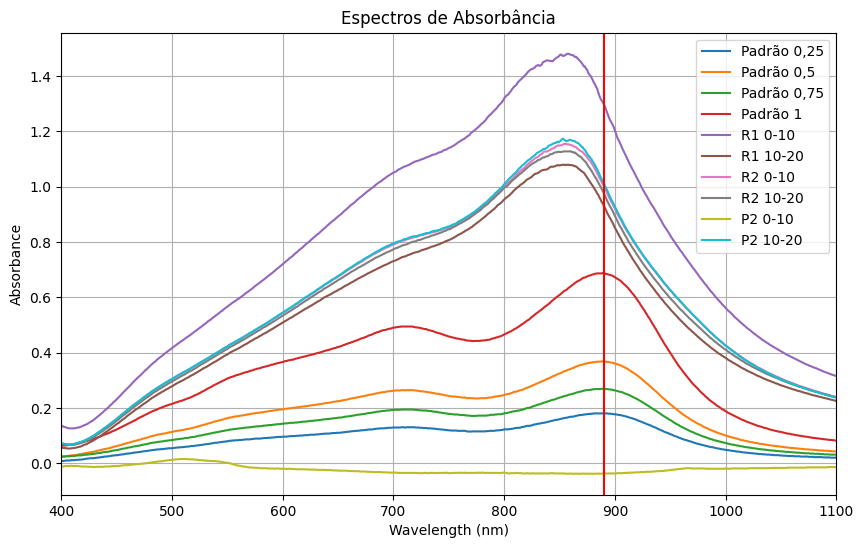

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

dataframes = [
    (p025_hcl1M, "Padrão 0,25"),
    (p05_hcl1M, "Padrão 0,5"),
    (p075_hcl1M, "Padrão 0,75"),
    (p1_hcl1M, "Padrão 1"),
    (r1_10_hcl1M, "R1 0-10"),
    (r1_20_hcl1M, "R1 10-20"),
    (r2_10_hcl1M, "R2 0-10"),
    (r2_20_hcl1M, "R2 10-20"),
    (p2_10_hcl1M, "P2 0-10"),
    (p2_20_hcl1M, "P2 10-20")
]

plt.figure(figsize=(10,6))

for df, label in dataframes:
    plt.plot(df["Wavelength (nm)"], df["Absorbance"], label=label)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Espectros de Absorbância")
plt.legend()
plt.xlim(400, 1100)
plt.grid(True)
plt.axvline(x=890, color = 'red')
plt.show()

In [21]:
#Curva de calibração
valores_padroes_hcl1M = [max(padrao['Absorbance'].loc[(padrao['Wavelength (nm)'] <= 900) & (padrao['Wavelength (nm)']>=800)]) for padrao in lista_padroes_hcl1M]

y_hcl1M = valores_padroes_hcl1M

y_hcl1M.pop(2)

X = np.delete(X, 2, axis=0).reshape(-1, 1)

modelo.fit(X, y_hcl1M)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


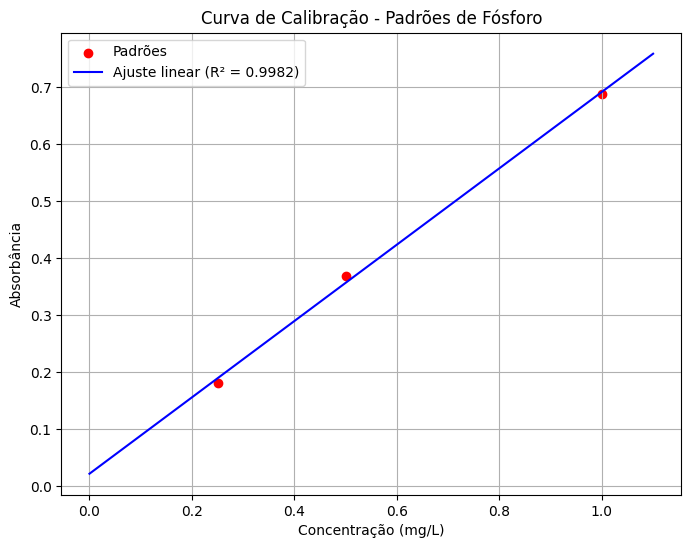

Equação da curva: Absorbância = 0.6706 * Concentração + 0.0215
R² = 0.9982


In [22]:
x_fit = np.linspace(0, 1.1, 90).reshape(-1,1)
y_fit = modelo.predict(x_fit)

r2 = modelo.score(X, y_hcl1M)

a_hcl1M = modelo.coef_[0]
b_hcl1M = modelo.intercept_

plt.figure(figsize=(8,6))
plt.scatter(X, y_hcl1M, color='red', label='Padrões')
plt.plot(x_fit, y_fit, color='blue', label=f'Ajuste linear (R² = {r2:.4f})')
plt.xlabel("Concentração (mg/L)")
plt.ylabel("Absorbância")
plt.title("Curva de Calibração - Padrões de Fósforo")
plt.legend()
plt.grid(True)
plt.show()

print(f"Equação da curva: Absorbância = {modelo.coef_[0]:.4f} * Concentração + {modelo.intercept_:.4f}")
print(f"R² = {r2:.4f}")

In [23]:
# Quantificando P hcl1M

valores_amostras_hcl1M = [max(amostra['Absorbance'].loc[(amostra['Wavelength (nm)'] <= 900) & (amostra['Wavelength (nm)']>=800)]) for amostra in lista_amostras_hcl1M]

R1_0_10_hcl1M = pi_calc(valores_amostras_hcl1M[0], a_hcl1M, b_hcl1M, 1.25*3*4)
R1_10_20_hcl1M = pi_calc(valores_amostras_hcl1M[1], a_hcl1M, b_hcl1M, 1.25*3*4)
R2_0_10_hcl1M = pi_calc(valores_amostras_hcl1M[2], a_hcl1M, b_hcl1M, 1.25*3*4)
R2_10_20_hcl1M = pi_calc(valores_amostras_hcl1M[3], a_hcl1M, b_hcl1M, 1.25*3*4)
P2_0_10_hcl1M = pi_calc(valores_amostras_hcl1M[4], a_hcl1M, b_hcl1M, 1.25*3*4)
P2_10_20_hcl1M = pi_calc(valores_amostras_hcl1M[5], a_hcl1M, b_hcl1M, 1.25*3*4)

massa_R1_0_10  = 190.229   
massa_R1_10_20 = 230.149
massa_R2_0_10  = 204.355
massa_R2_10_20 = 243.412
massa_P2_0_10  = 211.802
massa_P2_10_20 = 219.833

densidades = []
valores_mg_dm3 = []

dens_R1010, p_R1010 = calc_densidade_P(massa_R1_0_10,  R1_0_10_hcl1M)
densidades.append(dens_R1010); valores_mg_dm3.append(p_R1010)

dens_R11020, p_R11020 = calc_densidade_P(massa_R1_10_20, R1_10_20_hcl1M)
densidades.append(dens_R11020); valores_mg_dm3.append(p_R11020)

dens_R2010, p_R2010 = calc_densidade_P(massa_R2_0_10,  R2_0_10_hcl1M)
densidades.append(dens_R2010); valores_mg_dm3.append(p_R2010)

dens_R21020, p_R21020 = calc_densidade_P(massa_R2_10_20, R2_10_20_hcl1M)
densidades.append(dens_R21020); valores_mg_dm3.append(p_R21020)

dens_P2010, p_P2010 = calc_densidade_P(massa_P2_0_10,  P2_0_10_hcl1M)
densidades.append(dens_P2010); valores_mg_dm3.append(p_P2010)

dens_P21020, p_P21020 = calc_densidade_P(massa_P2_10_20, P2_10_20_hcl1M)
densidades.append(dens_P21020); valores_mg_dm3.append(p_P21020)

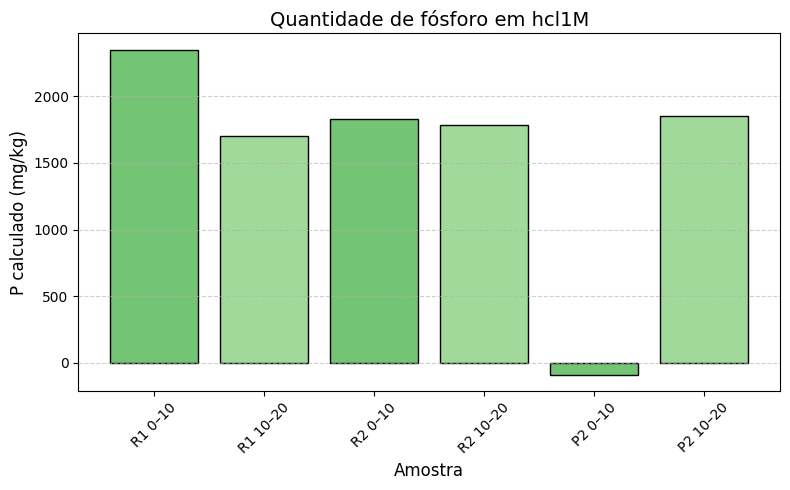

In [24]:
valores = [
    R1_0_10_hcl1M,
    R1_10_20_hcl1M,
    R2_0_10_hcl1M,
    R2_10_20_hcl1M,
    P2_0_10_hcl1M,
    P2_10_20_hcl1M
]

# Rótulos correspondentes
labels = [
    'R1 0–10',
    'R1 10–20',
    'R2 0–10',
    'R2 10–20',
    'P2 0–10',
    'P2 10–20'
]

# Gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, valores, color=['#74c476', '#a1d99b'], edgecolor='black')

plt.title('Quantidade de fósforo em hcl1M', fontsize=14)
plt.ylabel('P calculado (mg/kg)', fontsize=12)
plt.xlabel('Amostra', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Seus dados (mantém o mesmo formato)
valores_mgkg = np.array([
    R1_0_10_hcl1M,
    R1_10_20_hcl1M,
    R2_0_10_hcl1M,
    R2_10_20_hcl1M,
    P2_0_10_hcl1M,
    P2_10_20_hcl1M
], dtype=float)

valores_mg_dm3 = np.array(valores_mg_dm3, dtype=float)
densidades = np.array(densidades, dtype=float)

labels = ['R1 0–10','R1 10–20','R2 0–10','R2 10–20','P2 0–10','P2 10–20']

def colors_for(vals):
    return ['#74c476' if v >= 0 else '#d9d9d9' for v in vals]

# Exibir dados no terminal
for label, dens, mgkg, mgdm3 in zip(labels, densidades, valores_mgkg, valores_mg_dm3):
    print(f"{label}: densidade = {dens:.4f} g/cm³  |  {mgkg:.2f} mg/kg  ->  {mgdm3:.2f} mg/dm³")

# Criação das duas colunas (subplots lado a lado)
fig = make_subplots(rows=1, cols=2, subplot_titles=("Concentração de P em extrator hcl1M (mg/kg)", "Concentração de P em extrator hcl1M (mg/dm³)"))

# --- Primeiro gráfico (mg/kg)
colors1 = colors_for(valores_mgkg)
texts1 = [f"{v:.2f}" if v >= 0 else "Não mensurável" for v in valores_mgkg]
fig.add_trace(
    go.Bar(
        x=labels,
        y=valores_mgkg,
        text=texts1,
        textposition="outside",
        marker=dict(color=colors1, line=dict(color='black', width=1)),
        name="P (mg/kg)"
    ),
    row=1, col=1
)

# --- Segundo gráfico (mg/dm³)
colors2 = colors_for(valores_mg_dm3)
texts2 = [f"{v:.2f}" if v >= 0 else "Não mensurável" for v in valores_mg_dm3]
fig.add_trace(
    go.Bar(
        x=labels,
        y=valores_mg_dm3,
        text=texts2,
        textposition="outside",
        marker=dict(color=colors2, line=dict(color='black', width=1)),
        name="P (mg/dm³)"
    ),
    row=1, col=2
)

# Layout geral
fig.update_layout(
    height=500,
    width=1000,
    title_text="Quantidade de fósforo total (hcl1M)",
    showlegend=False,
    plot_bgcolor='rgba(0,0,0,0)',
)
fig.update_yaxes(title_text="P (mg/kg)", row=1, col=1, zeroline=True, zerolinewidth=1, zerolinecolor='black')
fig.update_yaxes(title_text="P (mg/dm³)", row=1, col=2, zeroline=True, zerolinewidth=1, zerolinecolor='black')

fig.show()


R1 0–10: densidade = 1.9023 g/cm³  |  2350.62 mg/kg  ->  4471.56 mg/dm³
R1 10–20: densidade = 2.3015 g/cm³  |  1704.78 mg/kg  ->  3923.55 mg/dm³
R2 0–10: densidade = 2.0435 g/cm³  |  1827.19 mg/kg  ->  3733.95 mg/dm³
R2 10–20: densidade = 2.4341 g/cm³  |  1783.70 mg/kg  ->  4341.75 mg/dm³
P2 0–10: densidade = 2.1180 g/cm³  |  -87.78 mg/kg  ->  -185.91 mg/dm³
P2 10–20: densidade = 2.1983 g/cm³  |  1856.18 mg/kg  ->  4080.49 mg/dm³


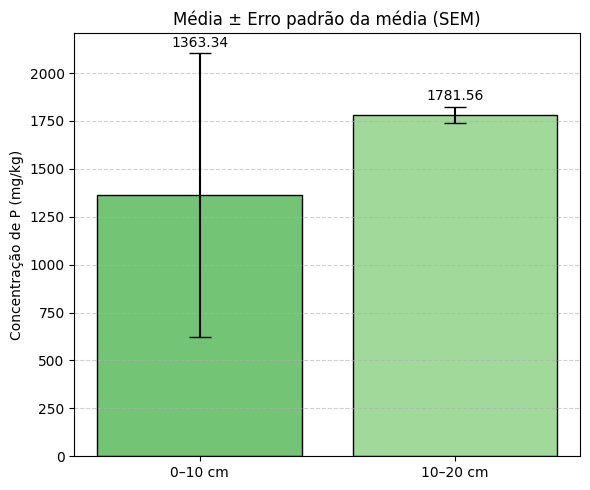

In [26]:
pi_0_10 = np.array([
    R1_0_10_hcl1M,
    R2_0_10_hcl1M,
    P2_0_10_hcl1M
])

pi_10_20 = np.array([
    R1_10_20_hcl1M,
    R2_10_20_hcl1M,
    P2_10_20_hcl1M
])

# Estatísticas
means = [pi_0_10.mean(), pi_10_20.mean()]
stds = [pi_0_10.std(ddof=1), pi_10_20.std(ddof=1)]  # desvio padrão
ns = [len(pi_0_10), len(pi_10_20)]
sems = [stds[i] / np.sqrt(ns[i]) for i in range(2)]  # erro padrão da média

# Gráfico de barras
labels = ['0–10 cm', '10–20 cm']
x = np.arange(len(labels))

plt.figure(figsize=(6, 5))
plt.bar(x, means, yerr=sems, capsize=8, color=['#74c476', '#a1d99b'], edgecolor='black')

# Estética
plt.xticks(x, labels)
plt.ylabel('Concentração de P (mg/kg)')
plt.title('Média ± Erro padrão da média (SEM)')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Mostrar valores numéricos acima das barras
for i, v in enumerate(means):
    plt.text(i, v + sems[i] + 0.01 * v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [27]:
pi_0_10 = np.array([R1_0_10_hcl1M, R2_0_10_hcl1M, P2_0_10_hcl1M])
pi_10_20 = np.array([R1_10_20_hcl1M, R2_10_20_hcl1M, P2_10_20_hcl1M])

F_stat, p_value = f_oneway(pi_0_10, pi_10_20)
print(f"F = {F_stat:.3f}, p = {p_value:.4f}")

F = 0.317, p = 0.6033


In [28]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Função para limpar valores negativos (não mensuráveis)
def limpar(valores):
    arr = np.array(valores, dtype=float)
    arr[arr <= 0] = np.nan
    return arr

# --- Dados mg/kg ---
pi_0_10_mgkg = limpar([R1_0_10_hcl1M, R2_0_10_hcl1M, P2_0_10_hcl1M])
pi_10_20_mgkg = limpar([R1_10_20_hcl1M, R2_10_20_hcl1M, P2_10_20_hcl1M])

# --- Dados mg/dm³ ---
pi_0_10_mgdm3 = limpar([p_R1010, p_R2010, p_P2010])

pi_10_20_mgdm3 = limpar([p_R11020, p_R21020, p_P21020])

# --- Estatísticas ---
def calcular_estatisticas(dados):
    mean = np.nanmean(dados)
    std = np.nanstd(dados, ddof=1)
    n = np.sum(~np.isnan(dados))
    sem = std / np.sqrt(n) if n > 0 else np.nan
    return mean, sem, n

means_mgkg, sems_mgkg, ns_mgkg = zip(*[calcular_estatisticas(pi_0_10_mgkg),
                                       calcular_estatisticas(pi_10_20_mgkg)])
means_mgdm3, sems_mgdm3, ns_mgdm3 = zip(*[calcular_estatisticas(pi_0_10_mgdm3),
                                          calcular_estatisticas(pi_10_20_mgdm3)])

# Labels e cores
labels = ['0–10 cm', '10–20 cm']
colors = ['#74c476', '#a1d99b']

# --- Criar subplots lado a lado ---
fig = make_subplots(rows=1, cols=2, subplot_titles=[
    'Quantidade de fósforo em hcl1M (mg/kg)',
    'Quantidade de fósforo em hcl1M (mg/dm³)'
])

# --- Função auxiliar para adicionar texto acima da barra + erro ---
def criar_textos(means, sems, ns):
    textos = []
    y_pos = []
    max_val = max([m + s for m, s in zip(means, sems) if not np.isnan(m)])
    for m, s, n in zip(means, sems, ns):
        if np.isnan(m):
            textos.append('Não mensurável')
            y_pos.append(0.05 * max_val)
        else:
            textos.append(f'{m:.2f}\n(n={n})')
            y_pos.append(m + s + 0.03*max_val)  # deslocamento acima da barra + erro
    return textos, y_pos

texts_mgkg, y_mgkg = criar_textos(means_mgkg, sems_mgkg, ns_mgkg)
texts_mgdm3, y_mgdm3 = criar_textos(means_mgdm3, sems_mgdm3, ns_mgdm3)

# --- Gráfico mg/kg ---
fig.add_trace(go.Bar(
    x=labels,
    y=means_mgkg,
    error_y=dict(type='data', array=sems_mgkg, visible=True, thickness=2, width=8),
    marker_color=colors,
    text=texts_mgkg,
    textposition='none',
), row=1, col=1)

# --- Adiciona anotações acima da barra + erro (mg/kg) ---
for xi, yi, txt in zip(labels, y_mgkg, texts_mgkg):
    fig.add_annotation(
        x=xi,
        y=yi,
        text=txt,
        showarrow=False,
        font=dict(size=12, color='black'),
        xanchor='center',
        yanchor='bottom',
        row=1, col=1
    )

# --- Gráfico mg/dm³ ---
fig.add_trace(go.Bar(
    x=labels,
    y=means_mgdm3,
    error_y=dict(type='data', array=sems_mgdm3, visible=True, thickness=2, width=8),
    marker_color=colors,
    text=texts_mgdm3,
    textposition='none',
), row=1, col=2)

# --- Adiciona anotações acima da barra + erro (mg/dm³) ---
for xi, yi, txt in zip(labels, y_mgdm3, texts_mgdm3):
    fig.add_annotation(
        x=xi,
        y=yi,
        text=txt,
        showarrow=False,
        font=dict(size=12, color='black'),
        xanchor='center',
        yanchor='bottom',
        row=1, col=2
    )

# --- Layout ---
fig.update_layout(
    height=500,
    width=1000,
    showlegend=False,
    title_text="Concentração de fósforo em hcl1M (mg/kg e mg/dm³)",
    title_x=0.5,
    bargap=0.3,
    plot_bgcolor='white',
    font=dict(size=12)
)

# Linhas de referência no zero
fig.update_yaxes(showgrid=True, gridcolor='lightgray', zeroline=True, zerolinecolor='black')

fig.show()


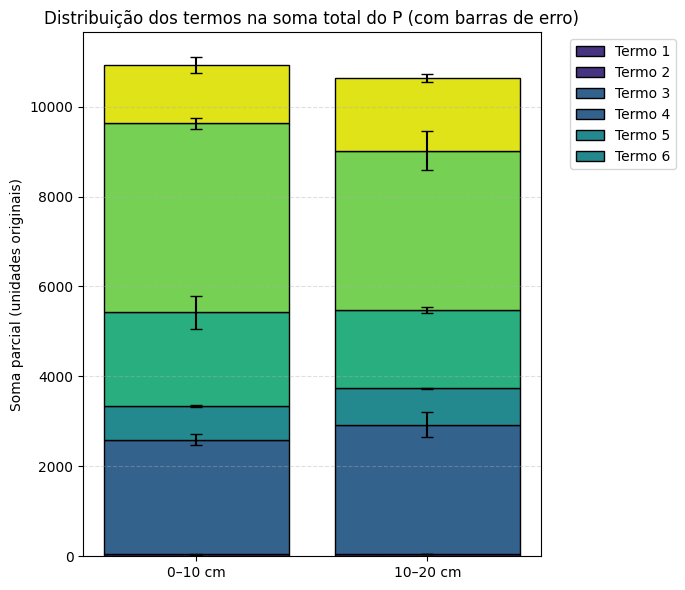

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dados organizados ---
R1_0_10 = [34.21, 2461.08, 754.08, 2350.62, 4113.53, 1179.57]
R2_0_10 = [54.99, 2638.34, 729.61, 1827.19, 4288.24, 1420.54]

R1_10_20 = [53.70, 3064.80, 793.40, 1704.78, 3859.41, 1541.90]
R2_10_20 = [59.47, 2682.02, 811.75, 1783.70, 3232.06, 1670.36]

# --- Médias e desvios ---
media_0_10 = np.mean([R1_0_10, R2_0_10], axis=0)
std_0_10   = np.std([R1_0_10, R2_0_10], axis=0, ddof=1)

media_10_20 = np.mean([R1_10_20, R2_10_20], axis=0)
std_10_20   = np.std([R1_10_20, R2_10_20], axis=0, ddof=1)

# --- Plot ---
fig, ax = plt.subplots(figsize=(7,6))
profundidades = ['0–10 cm', '10–20 cm']

# Cores distintas por termo
cores = plt.cm.viridis(np.linspace(0.15, 0.95, 6))

# Barras empilhadas
bottom_0_10 = np.zeros(1)
bottom_10_20 = np.zeros(1)

for i in range(6):
    ax.bar('0–10 cm', media_0_10[i], bottom=bottom_0_10,
           yerr=std_0_10[i], capsize=4, color=cores[i], edgecolor='k', label=f'Termo {i+1}' if i==0 else "")
    ax.bar('10–20 cm', media_10_20[i], bottom=bottom_10_20,
           yerr=std_10_20[i], capsize=4, color=cores[i], edgecolor='k')
    
    bottom_0_10 += media_0_10[i]
    bottom_10_20 += media_10_20[i]

ax.set_ylabel('Soma parcial (unidades originais)')
ax.set_title('Distribuição dos termos na soma total do P (com barras de erro)')
ax.legend([f'Termo {i+1}' for i in range(6)], bbox_to_anchor=(1.05,1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


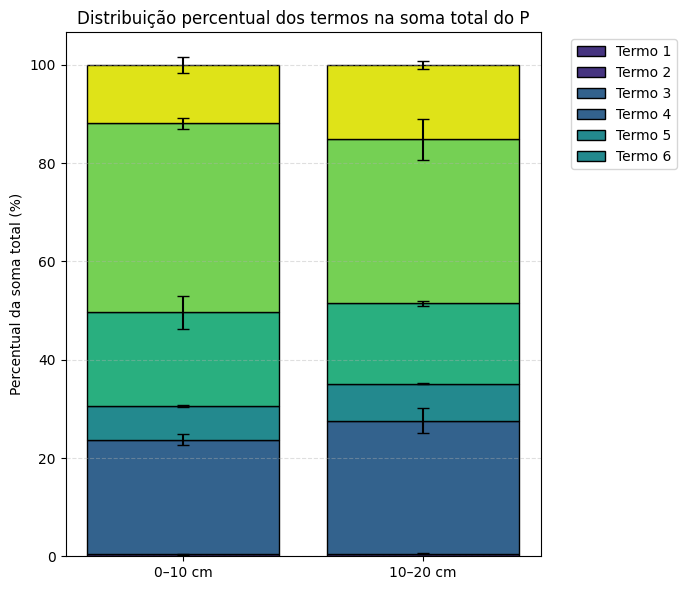

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dados ---
R1_0_10 = np.array([34.21, 2461.08, 754.08, 2350.62, 4113.53, 1179.57])
R2_0_10 = np.array([54.99, 2638.34, 729.61, 1827.19, 4288.24, 1420.54])

R1_10_20 = np.array([53.70, 3064.80, 793.40, 1704.78, 3859.41, 1541.90])
R2_10_20 = np.array([59.47, 2682.02, 811.75, 1783.70, 3232.06, 1670.36])

# --- Médias e desvios ---
media_0_10 = np.mean([R1_0_10, R2_0_10], axis=0)
std_0_10 = np.std([R1_0_10, R2_0_10], axis=0, ddof=1)

media_10_20 = np.mean([R1_10_20, R2_10_20], axis=0)
std_10_20 = np.std([R1_10_20, R2_10_20], axis=0, ddof=1)

# --- Normalização para % ---
total_0_10 = np.sum(media_0_10)
total_10_20 = np.sum(media_10_20)

media_0_10_norm = media_0_10 / total_0_10 * 100
std_0_10_norm = std_0_10 / total_0_10 * 100

media_10_20_norm = media_10_20 / total_10_20 * 100
std_10_20_norm = std_10_20 / total_10_20 * 100

# --- Plot ---
fig, ax = plt.subplots(figsize=(7,6))
profundidades = ['0–10 cm', '10–20 cm']
cores = plt.cm.viridis(np.linspace(0.15, 0.95, 6))

bottom_0_10 = 0
bottom_10_20 = 0

for i in range(6):
    ax.bar('0–10 cm', media_0_10_norm[i], bottom=bottom_0_10,
           yerr=std_0_10_norm[i], capsize=4, color=cores[i], edgecolor='k', label=f'Termo {i+1}' if i==0 else "")
    ax.bar('10–20 cm', media_10_20_norm[i], bottom=bottom_10_20,
           yerr=std_10_20_norm[i], capsize=4, color=cores[i], edgecolor='k')
    
    bottom_0_10 += media_0_10_norm[i]
    bottom_10_20 += media_10_20_norm[i]

ax.set_ylabel('Percentual da soma total (%)')
ax.set_title('Distribuição percentual dos termos na soma total do P')
ax.legend([f'Termo {i+1}' for i in range(6)], bbox_to_anchor=(1.05,1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [31]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Dados ---
R1_0_10 = np.array([34.21, 2461.08, 754.08, 2350.62, 4113.53, 1179.57])
R2_0_10 = np.array([54.99, 2638.34, 729.61, 1827.19, 4288.24, 1420.54])

R1_10_20 = np.array([53.70, 3064.80, 793.40, 1704.78, 3859.41, 1541.90])
R2_10_20 = np.array([59.47, 2682.02, 811.75, 1783.70, 3232.06, 1670.36])

# --- Médias e desvios ---
media_0_10 = np.mean([R1_0_10, R2_0_10], axis=0)
std_0_10 = np.std([R1_0_10, R2_0_10], axis=0, ddof=1)

media_10_20 = np.mean([R1_10_20, R2_10_20], axis=0)
std_10_20 = np.std([R1_10_20, R2_10_20], axis=0, ddof=1)

# --- Normalização para % ---
total_0_10 = np.sum(media_0_10)
total_10_20 = np.sum(media_10_20)

media_0_10_norm = media_0_10 / total_0_10 * 100
std_0_10_norm = std_0_10 / total_0_10 * 100

media_10_20_norm = media_10_20 / total_10_20 * 100
std_10_20_norm = std_10_20 / total_10_20 * 100

# --- Nomes dos termos (editáveis) ---
nomes_termos = [
    "Resina",
    "NaHCO3",
    "NaOH 0,1 M",
    "HCl 1 M",
    "NaOH 0,5 M",
    "Residual"
]

# --- Cores ---
cores = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725', '#ffa600']

# --- Subplots: 1 linha, 2 colunas ---
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Normalizado (%)", "Absoluto"),
                    shared_yaxes=False)

profundidades = ['0–10 cm', '10–20 cm']

# --- Gráfico Normalizado ---
for i in range(6):
    fig.add_trace(go.Bar(
        x=profundidades,
        y=[media_0_10_norm[i], media_10_20_norm[i]],
        name=nomes_termos[i],
        marker_color=cores[i],
        error_y=dict(
            type='data',
            array=[std_0_10_norm[i], std_10_20_norm[i]],
            visible=True,
            thickness=2,
            width=4,
            color='black'
        ),
    ), row=1, col=1)

# --- Gráfico Absoluto ---
for i in range(6):
    fig.add_trace(go.Bar(
        x=profundidades,
        y=[media_0_10[i], media_10_20[i]],
        marker_color=cores[i],
        showlegend=False,
        error_y=dict(
            type='data',
            array=[std_0_10[i], std_10_20[i]],
            visible=True,
            thickness=2,
            width=4,
            color='black'
        ),
    ), row=1, col=2)

# --- Layout geral ---
fig.update_layout(
    barmode='stack',
    title_text="Distribuição dos termos na soma total do P",
    yaxis_title="Percentual (%)",
    yaxis2_title="Concentração em mg/kg",
    legend_title="Termos",
    legend=dict(x=1.05, y=1, traceorder="normal"),
    bargap=0.25,
    width=1100,
    height=600,
    template="plotly_white"
)

fig.show()


In [32]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Dados ---
R1_0_10 = np.array([34.21, 2461.08, 754.08, 2350.62, 4113.53, 1179.57])
R2_0_10 = np.array([54.99, 2638.34, 729.61, 1827.19, 4288.24, 1420.54])

R1_10_20 = np.array([53.70, 3064.80, 793.40, 1704.78, 3859.41, 1541.90])
R2_10_20 = np.array([59.47, 2682.02, 811.75, 1783.70, 3232.06, 1670.36])

# --- Médias e desvios ---
media_0_10 = np.mean([R1_0_10, R2_0_10], axis=0)
std_0_10 = np.std([R1_0_10, R2_0_10], axis=0, ddof=1)

media_10_20 = np.mean([R1_10_20, R2_10_20], axis=0)
std_10_20 = np.std([R1_10_20, R2_10_20], axis=0, ddof=1)

# --- Normalização para % ---
total_0_10 = np.sum(media_0_10)
total_10_20 = np.sum(media_10_20)

media_0_10_norm = media_0_10 / total_0_10 * 100
std_0_10_norm = std_0_10 / total_0_10 * 100

media_10_20_norm = media_10_20 / total_10_20 * 100
std_10_20_norm = std_10_20 / total_10_20 * 100

# --- Nomes e cores ---
nomes_termos = ["Resina", "NaHCO3", "NaOH 0,1 M", "HCl 1 M", "NaOH 0,5 M", "Residual"]
cores = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725', '#ffa600']
profundidades = ['0–10 cm', '10–20 cm']

# --- Subplots ---
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Normalizado (%)", "Absoluto"),
                    shared_yaxes=False)

# --- Normalizado (%)
for i in range(6):
    fig.add_trace(go.Bar(
        x=profundidades,
        y=[media_0_10_norm[i], media_10_20_norm[i]],
        name=nomes_termos[i],
        marker_color=cores[i],
        error_y=dict(
            type='data',
            array=[std_0_10_norm[i], std_10_20_norm[i]],
            visible=True,
            thickness=1.5,   # mais fino
            width=2,         # abas menores
            color='black'
        ),
    ), row=1, col=1)

# --- Absoluto (mg/kg)
for i in range(6):
    fig.add_trace(go.Bar(
        x=profundidades,
        y=[media_0_10[i], media_10_20[i]],
        marker_color=cores[i],
        showlegend=False,
        error_y=dict(
            type='data',
            array=[std_0_10[i], std_10_20[i]],
            visible=True,
            thickness=1.5,
            width=2,
            color='black'
        ),
    ), row=1, col=2)

# --- Layout geral ---
fig.update_layout(
    barmode='stack',
    title_text="Distribuição dos termos na soma total do P",
    yaxis_title="Percentual (%)",
    yaxis2_title="Concentração em mg/kg",
    legend_title="Termos",
    legend=dict(x=1.05, y=1, traceorder="normal"),
    bargap=0.25,          # espaço entre grupos
    bargroupgap=0.05,     # espaço entre barras no mesmo grupo
    width=1100,
    height=600,
    template="plotly_white"
)

# --- Melhorar proporção visual ---
fig.update_yaxes(rangemode="tozero")  # garante início no zero
fig.update_traces(marker_line_width=0.5)

fig.show()


In [36]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Dados ---
R1_0_10 = np.array([34.21, 2461.08, 754.08, 2350.62, 4113.53, 1179.57])
R2_0_10 = np.array([54.99, 2638.34, 729.61, 1827.19, 4288.24, 1420.54])

R1_10_20 = np.array([53.70, 3064.80, 793.40, 1704.78, 3859.41, 1541.90])
R2_10_20 = np.array([59.47, 2682.02, 811.75, 1783.70, 3232.06, 1670.36])

# --- Combinar tudo em 0–20 cm ---
# Cada termo agora tem 4 valores (R1_0_10, R2_0_10, R1_10_20, R2_10_20)
dados_0_20 = np.vstack([R1_0_10, R2_0_10, R1_10_20, R2_10_20])

# --- Média e desvio (por termo) ---
media_0_20 = np.mean(dados_0_20, axis=0)
std_0_20 = np.std(dados_0_20, axis=0, ddof=1)

# --- Normalização para % ---
total_0_20 = np.sum(media_0_20)
media_0_20_norm = media_0_20 / total_0_20 * 100
std_0_20_norm = std_0_20 / total_0_20 * 100

# --- Nomes dos termos ---
nomes_termos = [
    "Resina",
    "NaHCO3",
    "NaOH 0,1 M",
    "HCl 1 M",
    "NaOH 0,5 M",
    "Residual"
]

# --- Cores ---
cores = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725', '#ffa600']

# --- Subplots: Normalizado e Absoluto ---
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Normalizado (%)", "Absoluto"),
                    shared_yaxes=False)

# --- Gráfico Normalizado ---
for i in range(6):
    fig.add_trace(go.Bar(
        x=["0–20 cm"],
        y=[media_0_20_norm[i]],
        name=nomes_termos[i],
        marker_color=cores[i],
        error_y=dict(
            type='data',
            array=[std_0_20_norm[i]],
            visible=True,
            thickness=2,
            width=4,
            color='black'
        ),
    ), row=1, col=1)

# --- Gráfico Absoluto ---
for i in range(6):
    fig.add_trace(go.Bar(
        x=["0–20 cm"],
        y=[media_0_20[i]],
        marker_color=cores[i],
        showlegend=False,
        error_y=dict(
            type='data',
            array=[std_0_20[i]],
            visible=True,
            thickness=2,
            width=4,
            color='black'
        ),
    ), row=1, col=2)

# --- Layout ---
fig.update_layout(
    barmode='stack',
    title_text="Distribuição dos termos de P (0–20 cm)",
    yaxis_title="Percentual (%)",
    yaxis2_title="Concentração em mg/kg",
    legend_title="Termos",
    legend=dict(x=1.05, y=1),
    bargap=0.25,
    width=1000,
    height=600,
    template="plotly_white"
)

fig.show()
